# 📈 Price Data Exploration

**Goal**: Understand the raw stock price data we downloaded from Yahoo Finance before combining it with news sentiment.

We'll answer three key questions:
1. **Price trends over time?** — How did AAPL and MSFT move during our analysis period?
2. **Volatility patterns?** — How much do prices swing day-to-day? Are there calm vs turbulent periods?
3. **Trading volume patterns?** — When is trading activity highest?

We'll also look at **daily returns**, which is what we'll ultimately try to predict with sentiment signals.

**Data source**: `data/raw/prices_<TICKER>_2025-11-01_to_2026-02-13.csv` (downloaded via yfinance)

## Step 1 — Load the data

We load both price CSV files (AAPL and MSFT), skip the extra ticker-name row that yfinance adds, and combine them into a single DataFrame. We also compute **daily returns** — the percentage change in closing price from one day to the next — since that's the key metric we'll try to predict later with sentiment.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RAW_DATA_DIR = Path("../../data/raw")

def load_prices(ticker: str) -> pd.DataFrame:
    """Load a price CSV, handling yfinance's extra header row."""
    filepath = RAW_DATA_DIR / f"prices_{ticker}_2025-11-01_to_2026-02-13.csv"
    # Skip the second row (index 1) which contains repeated ticker names
    df = pd.read_csv(filepath, skiprows=[1])
    df["Date"] = pd.to_datetime(df["Date"])
    df["ticker"] = ticker
    return df

# Load and combine both tickers
aapl = load_prices("AAPL")
msft = load_prices("MSFT")
prices = pd.concat([aapl, msft], ignore_index=True)

# Compute daily return (%) — percentage change in closing price day-over-day
prices = prices.sort_values(["ticker", "Date"])
prices["daily_return"] = prices.groupby("ticker")["Close"].pct_change() * 100

print(f"Loaded {len(prices)} trading days ({len(aapl)} AAPL + {len(msft)} MSFT)")
print(f"Date range: {prices['Date'].min().date()} → {prices['Date'].max().date()}")
prices.head(3)

Loaded 140 trading days (70 AAPL + 70 MSFT)
Date range: 2025-11-03 → 2026-02-12


,Date,Open,High,Low,Close,Volume,ticker,daily_return
0,2025-11-03,269.905566,270.334741,265.743486,268.538147,50194600,AAPL,NaN
1,2025-11-04,267.819507,270.973499,267.110866,269.526276,49274800,AAPL,0.367966
2,2025-11-05,268.098980,271.183128,266.422183,269.626099,43683100,AAPL,0.037036


## Step 2 — Price trends over time

The most basic question: **how did the stock price move over our analysis period?** We plot the daily closing price for both tickers. We also normalize prices to a common starting point (100) so we can compare AAPL and MSFT performance directly, even though they trade at very different price levels.

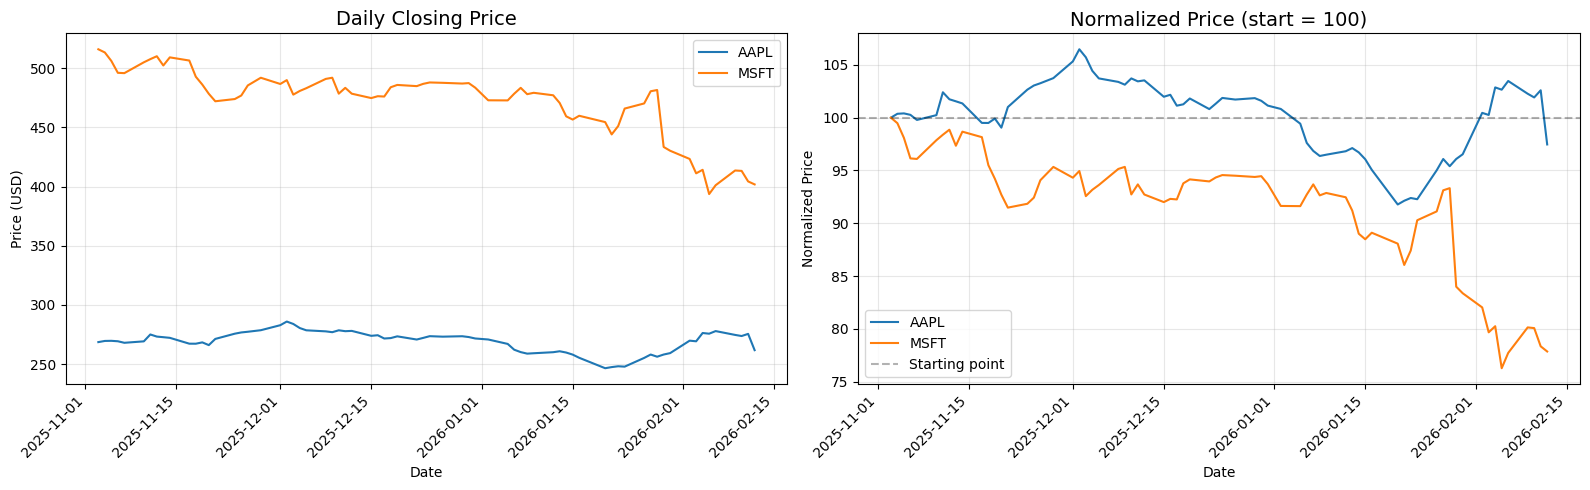

AAPL: $268.54 → $261.73 (total return: -2.5%)
MSFT: $516.06 → $401.84 (total return: -22.1%)


In [2]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Left: Absolute closing prices ---
for ticker in ["AAPL", "MSFT"]:
    subset = prices[prices["ticker"] == ticker]
    axes[0].plot(subset["Date"], subset["Close"], label=ticker)

axes[0].set_title("Daily Closing Price", fontsize=14)
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price (USD)")
axes[0].legend()
axes[0].grid(alpha=0.3)

# --- Right: Normalized prices (start = 100) for direct comparison ---
for ticker in ["AAPL", "MSFT"]:
    subset = prices[prices["ticker"] == ticker].copy()
    first_price = subset["Close"].iloc[0]
    subset["normalized"] = subset["Close"] / first_price * 100
    axes[1].plot(subset["Date"], subset["normalized"], label=ticker)

axes[1].set_title("Normalized Price (start = 100)", fontsize=14)
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Normalized Price")
axes[1].axhline(100, color="black", linestyle="--", alpha=0.3, label="Starting point")
axes[1].legend()
axes[1].grid(alpha=0.3)

fig.autofmt_xdate(rotation=45)
plt.tight_layout()
plt.show()

# Print total return for each ticker
for ticker in ["AAPL", "MSFT"]:
    subset = prices[prices["ticker"] == ticker]
    total_return = (subset["Close"].iloc[-1] / subset["Close"].iloc[0] - 1) * 100
    print(f"{ticker}: ${subset['Close'].iloc[0]:.2f} → ${subset['Close'].iloc[-1]:.2f} "
          f"(total return: {total_return:+.1f}%)")

## Step 3 — Volatility patterns

Volatility measures how much prices swing. We look at two things:
- **Daily returns** — the percentage change in closing price each day. Large positive or negative returns indicate high volatility days.
- **Rolling volatility** — the standard deviation of daily returns over a 10-day window. This shows us whether the stock was in a calm or turbulent period.

High volatility periods often coincide with big news events — exactly what we want to detect with sentiment analysis later.

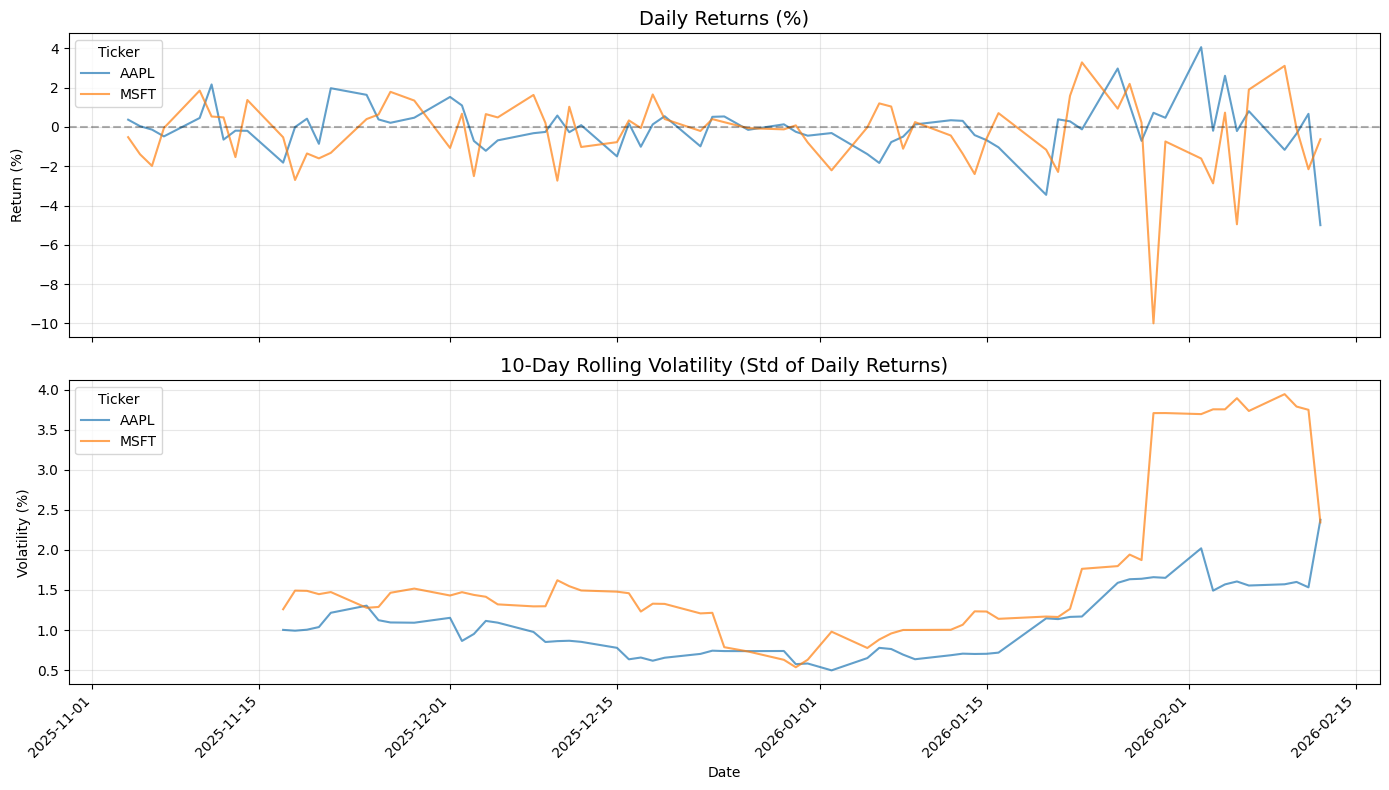

Daily return statistics (%):
        count  mean   std   min   25%   50%   75%   max
ticker                                                 
AAPL     69.0 -0.03  1.28 -5.00 -0.65 -0.12  0.46  4.06
MSFT     69.0 -0.34  1.91 -9.99 -1.32 -0.06  0.67  3.28


In [3]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

for ticker in ["AAPL", "MSFT"]:
    subset = prices[prices["ticker"] == ticker].copy()

    # --- Top: Daily returns ---
    axes[0].plot(subset["Date"], subset["daily_return"], label=ticker, alpha=0.7)

    # --- Bottom: 10-day rolling volatility (std of daily returns) ---
    subset["rolling_vol"] = subset["daily_return"].rolling(window=10).std()
    axes[1].plot(subset["Date"], subset["rolling_vol"], label=ticker, alpha=0.7)

axes[0].set_title("Daily Returns (%)", fontsize=14)
axes[0].set_ylabel("Return (%)")
axes[0].axhline(0, color="black", linestyle="--", alpha=0.3)
axes[0].legend(title="Ticker")
axes[0].grid(alpha=0.3)

axes[1].set_title("10-Day Rolling Volatility (Std of Daily Returns)", fontsize=14)
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Volatility (%)")
axes[1].legend(title="Ticker")
axes[1].grid(alpha=0.3)

fig.autofmt_xdate(rotation=45)
plt.tight_layout()
plt.show()

# Print volatility summary
print("Daily return statistics (%):")
print(prices.groupby("ticker")["daily_return"].describe().round(2).to_string())

## Step 4 — Trading volume patterns

Volume tells us how many shares were traded each day. High volume usually means:
- **Big news** (earnings, product launches, scandals)
- **High conviction** — many traders agree something significant happened
- **Higher volatility** — volume and volatility often spike together

Volume spikes are another signal we can later correlate with news sentiment.

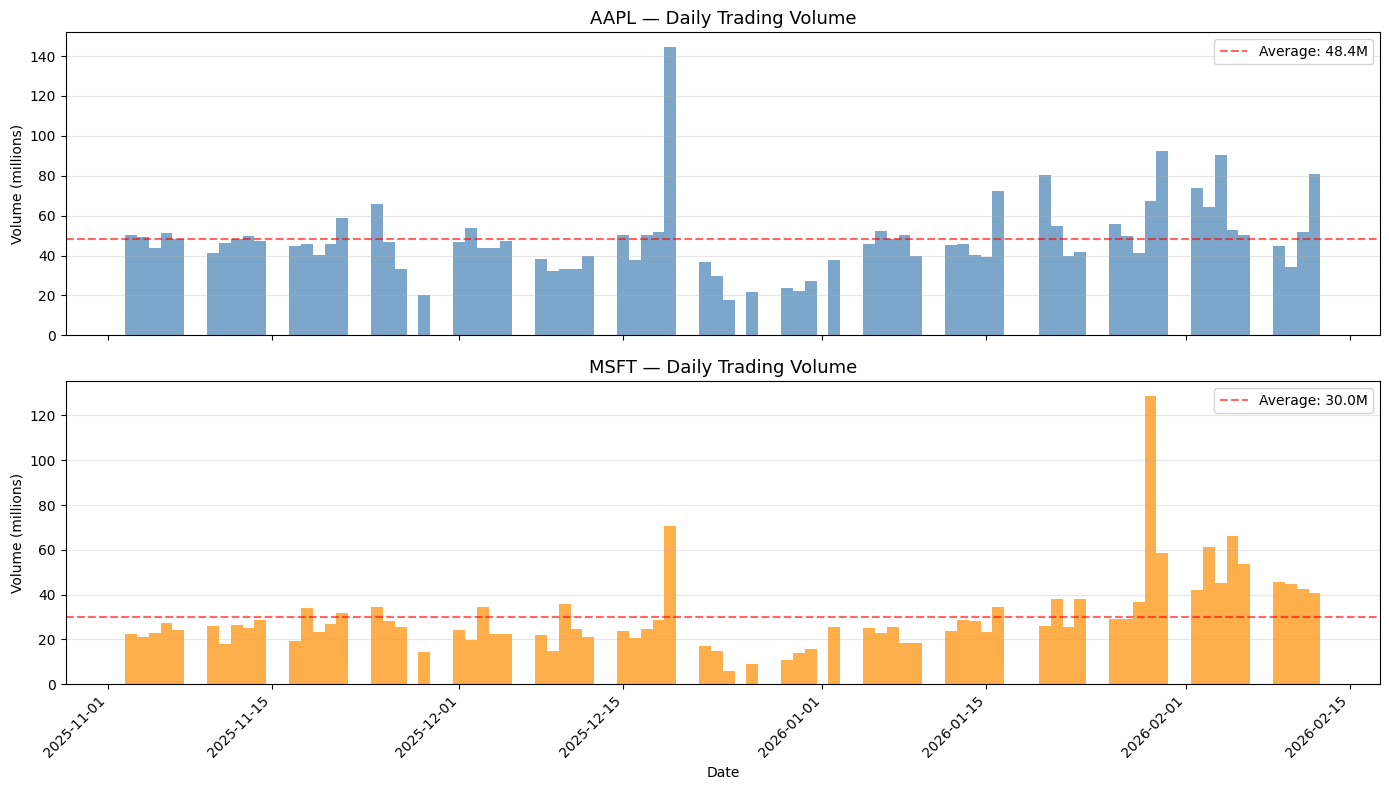

Volume statistics (shares):

AAPL:
  Average daily volume: 48,374,406
  Max volume day: 2025-12-19 (144,632,000 shares)

MSFT:
  Average daily volume: 30,029,743
  Max volume day: 2026-01-29 (128,855,300 shares)


In [4]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for i, ticker in enumerate(["AAPL", "MSFT"]):
    subset = prices[prices["ticker"] == ticker]
    avg_volume = subset["Volume"].mean()

    axes[i].bar(subset["Date"], subset["Volume"] / 1e6, width=1, alpha=0.7, color="steelblue" if i == 0 else "darkorange")
    axes[i].axhline(avg_volume / 1e6, color="red", linestyle="--", alpha=0.6, label=f"Average: {avg_volume / 1e6:.1f}M")
    axes[i].set_title(f"{ticker} — Daily Trading Volume", fontsize=13)
    axes[i].set_ylabel("Volume (millions)")
    axes[i].legend()
    axes[i].grid(axis="y", alpha=0.3)

axes[1].set_xlabel("Date")
fig.autofmt_xdate(rotation=45)
plt.tight_layout()
plt.show()

# Print volume summary
print("Volume statistics (shares):")
for ticker in ["AAPL", "MSFT"]:
    subset = prices[prices["ticker"] == ticker]
    print(f"\n{ticker}:")
    print(f"  Average daily volume: {subset['Volume'].mean():,.0f}")
    print(f"  Max volume day: {subset.loc[subset['Volume'].idxmax(), 'Date'].date()} "
          f"({subset['Volume'].max():,.0f} shares)")

## Step 5 — Daily return distribution

This is the most important step for our project. When we build the trading signal model, we'll try to predict whether the stock goes **up or down** on a given day based on news sentiment. Here we look at:
- The distribution of daily returns — are they roughly symmetric or skewed?
- How often do large moves (>2%) happen? These extreme days are where sentiment signals are most valuable.

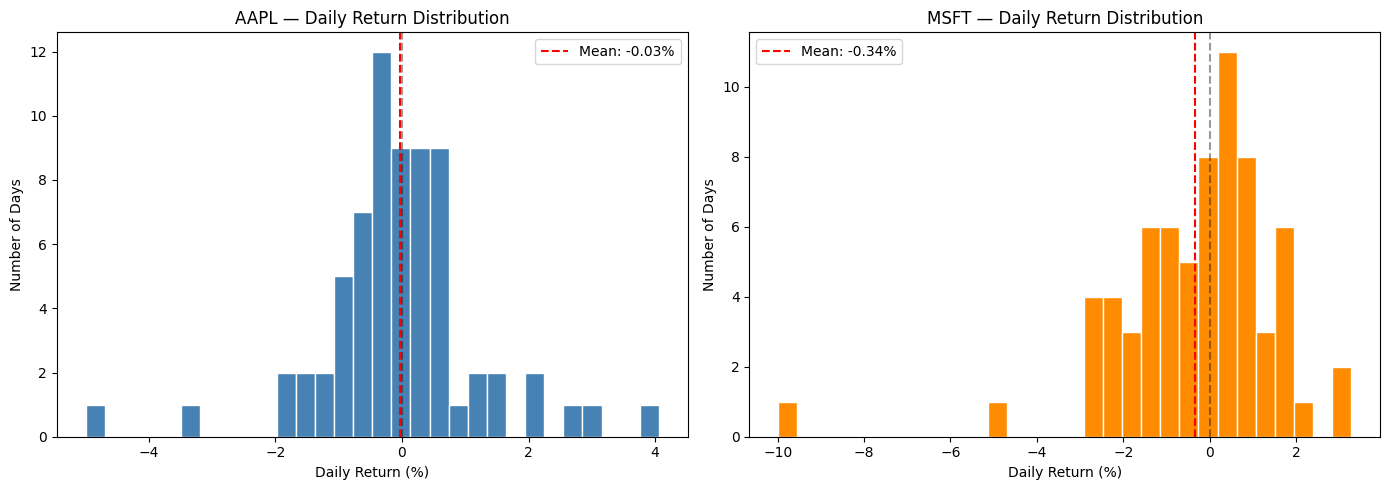


AAPL:
  Up days: 33 (48%) | Down days: 36 (52%)
  Large moves (>2%): 6 days
  Biggest gain: +4.06% | Biggest loss: -5.00%

MSFT:
  Up days: 32 (46%) | Down days: 37 (54%)
  Large moves (>2%): 13 days
  Biggest gain: +3.28% | Biggest loss: -9.99%


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, ticker in enumerate(["AAPL", "MSFT"]):
    subset = prices[prices["ticker"] == ticker].dropna(subset=["daily_return"])
    color = "steelblue" if i == 0 else "darkorange"

    axes[i].hist(subset["daily_return"], bins=30, color=color, edgecolor="white")
    axes[i].axvline(0, color="black", linestyle="--", alpha=0.4)
    axes[i].axvline(subset["daily_return"].mean(), color="red", linestyle="--",
                    label=f'Mean: {subset["daily_return"].mean():.2f}%')
    axes[i].set_title(f"{ticker} — Daily Return Distribution", fontsize=12)
    axes[i].set_xlabel("Daily Return (%)")
    axes[i].set_ylabel("Number of Days")
    axes[i].legend()

plt.tight_layout()
plt.show()

# Print key stats
for ticker in ["AAPL", "MSFT"]:
    subset = prices[prices["ticker"] == ticker].dropna(subset=["daily_return"])
    up_days = (subset["daily_return"] > 0).sum()
    down_days = (subset["daily_return"] < 0).sum()
    big_moves = (subset["daily_return"].abs() > 2).sum()
    print(f"\n{ticker}:")
    print(f"  Up days: {up_days} ({up_days / len(subset) * 100:.0f}%) | "
          f"Down days: {down_days} ({down_days / len(subset) * 100:.0f}%)")
    print(f"  Large moves (>2%): {big_moves} days")
    print(f"  Biggest gain: {subset['daily_return'].max():+.2f}% | "
          f"Biggest loss: {subset['daily_return'].min():+.2f}%")